<a href="https://colab.research.google.com/github/arlaine4/Satellite-Imagery/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install boto3
!pip install awscli

In [23]:
import boto3
import os
import json
import io
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import display

1️⃣ AWS S3 client setup

In [30]:
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_REGION = os.getenv("AWS_DEFAULT_REGION")
AWS_BUCKET = os.getenv("BUCKET_NAME")

s3_client = boto3.client(
    "s3",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_REGION
)

2️⃣ Connect to AWS S3 (Access Dataset)

In [31]:
# AWS Configuration
BUCKET_NAME = AWS_BUCKET  # Your S3 bucket name
ANNOTATION_FILE = "train_labels/xView_train.geojson"  # Annotation file in S3

# Initialize S3 client
s3_client = boto3.client("s3")

# List all files in S3 bucket
response = s3_client.list_objects_v2(Bucket=BUCKET_NAME)

# Print the first 10 files
for obj in response.get("Contents", [])[:10]:
    print(obj["Key"])

train_images/
train_images/10.tif
train_images/100.tif
train_images/102.tif
train_images/1036.tif
train_images/1037.tif
train_images/104.tif
train_images/1042.tif
train_images/1044.tif
train_images/1046.tif


3️⃣ Download & Process xView Annotations from S3



In [32]:
# Read the annotation file from S3
obj = s3_client.get_object(Bucket=BUCKET_NAME, Key=ANNOTATION_FILE)
annotations = json.load(io.BytesIO(obj["Body"].read()))

# Print dataset structure
print(json.dumps(annotations, indent=2)[:2000])

{
  "crs": {
    "properties": {
      "name": "urn:ogc:def:crs:OGC:1.3:CRS84"
    },
    "type": "name"
  },
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {
        "bounds_imcoords": "2712,1145,2746,1177",
        "edited_by": "wwoscarbecerril",
        "cat_id": "1040010028371A00",
        "type_id": 73,
        "ingest_time": "2017/07/24 12:49:09.118+00",
        "index_right": 2356,
        "image_id": "2355.tif",
        "point_geom": "0101000020E6100000616E4E6406A256C03BE6ADA0D6212D40",
        "feature_id": 374410,
        "grid_file": "Grid2.shp"
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -90.53169885094464,
              14.56603647302396
            ],
            [
              -90.53169885094464,
              14.56614473506768
            ],
            [
              -90.53158140073565,
              14.56614473506768
            ],
        

4️⃣ Convert Annotations into a DataFrame (Bounding Box Extraction)

In [56]:
# Extract bounding box data
features = annotations["features"]
rows = []

for feature in features:
    properties = feature["properties"]
    geometry = feature["geometry"]

    # Extract bounds_imcoords and split into x_min, y_min, x_max, y_max
    bounds_imcoords = properties.get("bounds_imcoords", "")
    if bounds_imcoords:
        x_min, y_min, x_max, y_max = map(int, bounds_imcoords.split(','))
    else:
        x_min, y_min, x_max, y_max = None, None, None, None

    # Extract latitude-longitude coordinates
    lat_lon_coords = geometry.get("coordinates", [[]])
    if lat_lon_coords and len(lat_lon_coords[0]) > 0:
        lon_min, lat_min = lat_lon_coords[0][0]  # First coordinate (x_min, y_min)
        lon_max, lat_max = lat_lon_coords[0][2]  # Third coordinate (x_max, y_max)
    else:
        lon_min, lat_min, lon_max, lat_max = None, None, None, None

    rows.append({
        "image_id": properties["image_id"],
        "class_id": properties["type_id"],
        "x_min": x_min,
        "y_min": y_min,
        "x_max": x_max,
        "y_max": y_max,
        "lon_min": lon_min,
        "lat_min": lat_min,
        "lon_max": lon_max,
        "lat_max": lat_max,
    })

# Create a DataFrame
df = pd.DataFrame(rows)

# Display extracted annotations
display(df)


,image_id,class_id,x_min,y_min,x_max,y_max,lon_min,lat_min,lon_max,lat_max
0,2355.tif,73,2712,1145,2746,1177,-90.531699,14.566036,-90.531581,14.566145
1,2355.tif,73,2720,2233,2760,2288,-90.531672,14.562217,-90.531533,14.562408
2,2355.tif,73,2687,1338,2740,1399,-90.531785,14.565273,-90.531603,14.565484
3,2355.tif,73,2691,1201,2730,1268,-90.531772,14.565723,-90.531637,14.565953
4,2355.tif,73,2671,838,2714,869,-90.531841,14.567095,-90.531692,14.567202
...,...,...,...,...,...,...,...,...,...,...
601932,389.tif,73,710,1900,738,1925,98.895898,3.655721,98.895996,3.655808
601933,389.tif,73,2091,258,2138,295,98.900702,3.661390,98.900867,3.661519
601934,389.tif,73,2106,361,2124,379,98.900755,3.661100,98.900818,3.661160
601935,389.tif,73,1917,38,1958,64,98.900098,3.662196,98.900242,3.662286


5️⃣ Process Images from S3

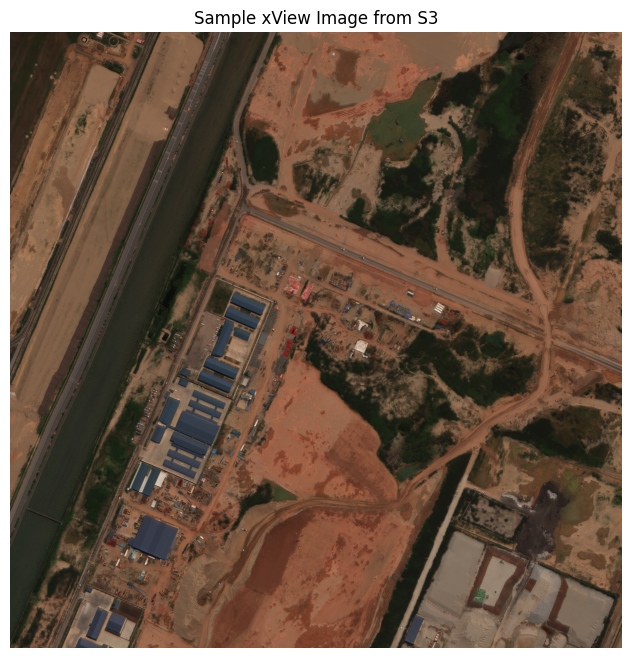

In [38]:
def load_image_from_s3(bucket, key):
    """Loads an image directly from S3 into memory."""
    obj = s3_client.get_object(Bucket=bucket, Key=key)
    img_array = np.asarray(bytearray(obj["Body"].read()), dtype=np.uint8)
    return cv2.imdecode(img_array, cv2.IMREAD_COLOR)

# Load a sample image from S3
image_key = "train_images/1042.tif"  # Example file path in S3
image = load_image_from_s3(BUCKET_NAME, image_key)

# Convert BGR (OpenCV default) to RGB for Matplotlib
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title("Sample xView Image from S3")
plt.axis("off")
plt.show()


6️⃣ Store Preprocessed Data Back into S3

In [57]:
# Save processed annotations back to S3
processed_annotations = "processed_xView_annotations.csv"
df.to_csv(processed_annotations, index=False)

# Upload to S3
s3_client.upload_file(processed_annotations, BUCKET_NAME, "processed_data/processed_xView_annotations.csv")

print("Processed annotations uploaded to S3!")


Processed annotations uploaded to S3!


In [58]:
processed_anno = s3_client.get_object(Bucket=BUCKET_NAME, Key="processed_data/processed_xView_annotations.csv")
df = pd.read_csv(io.BytesIO(processed_anno["Body"].read()))
df[df['image_id'] == "10.tif"]

,image_id,class_id,x_min,y_min,x_max,y_max,lon_min,lat_min,lon_max,lat_max
144655,10.tif,73,1409,732,1430,743,-23.475366,14.954060,-23.475307,14.954091
144656,10.tif,23,1188,466,1216,480,-23.475992,14.954804,-23.475912,14.954843
144657,10.tif,73,1639,37,1706,119,-23.474715,14.955827,-23.474526,14.956059
144658,10.tif,73,1558,416,1620,474,-23.474944,14.954986,-23.474769,14.954823
144659,10.tif,73,1594,581,1622,600,-23.474843,14.954520,-23.474765,14.954466
...,...,...,...,...,...,...,...,...,...,...
144713,10.tif,73,912,544,959,618,-23.476640,14.954415,-23.476772,14.954624
144714,10.tif,73,1147,517,1207,588,-23.475939,14.954700,-23.476108,14.954498
144715,10.tif,73,823,502,867,558,-23.477025,14.954744,-23.476902,14.954584
144716,10.tif,73,1262,1004,1281,1023,-23.475783,14.953269,-23.475729,14.953323


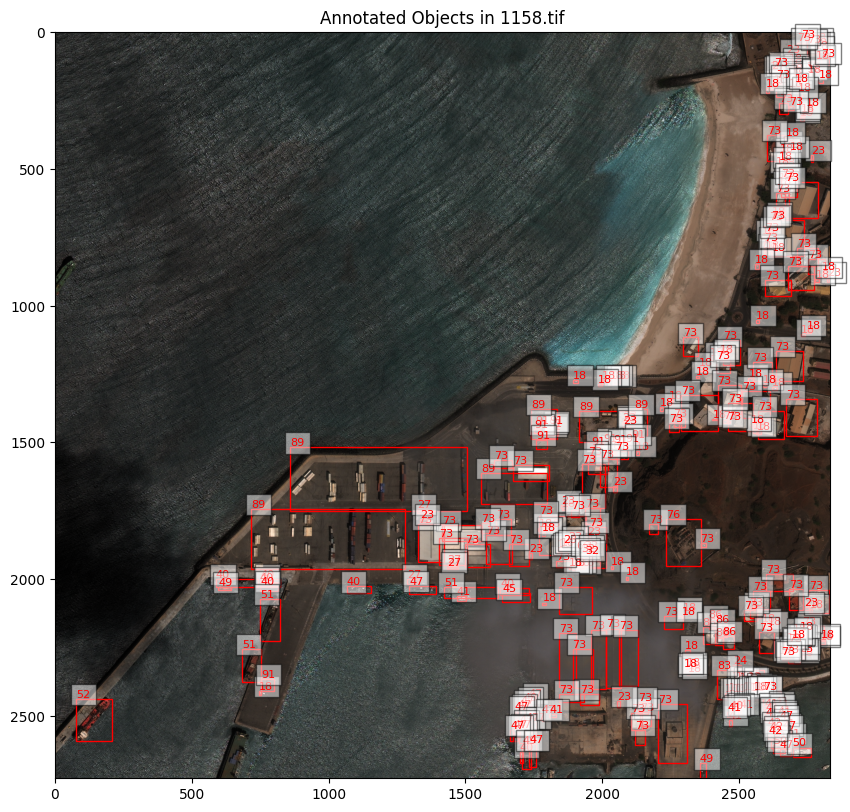

In [65]:
# Select an image and its bounding boxes
image = load_image_from_s3(BUCKET_NAME, "train_images/1158.tif")
image_id = "1158.tif"
bboxes = df[df["image_id"] == image_id]  # Get bounding boxes for this image

# Convert image from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Filter valid bounding boxes
bboxes = bboxes[
    (bboxes["x_min"] < bboxes["x_max"]) &
    (bboxes["y_min"] < bboxes["y_max"]) &
    (bboxes["x_min"] >= 0) &
    (bboxes["y_min"] >= 0) &
    (bboxes["x_max"] <= image.shape[1]) &
    (bboxes["y_max"] <= image.shape[0])
]

# Plot image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(image)

for _, row in bboxes.iterrows():
    x_min, y_min, x_max, y_max = row["x_min"], row["y_min"], row["x_max"], row["y_max"]
    width, height = x_max - x_min, y_max - y_min

    plt.gca().add_patch(plt.Rectangle((x_min, y_min), width, height,
                                      edgecolor='red', facecolor='none', linewidth=1))
    # Add class ID label
    plt.text(x_min, y_min - 5, f"{row['class_id']}", color='red', fontsize=8, bbox=dict(facecolor='white', alpha=0.5))

plt.title(f"Annotated Objects in {image_id}")
plt.show()

In [75]:
import boto3
import os
import io
from PIL import Image
import json
import pandas as pd

# Function to fetch a file from S3
def fetch_file_from_s3(bucket_name, file_key):
    obj = s3_client.get_object(Bucket=bucket_name, Key=file_key)
    return io.BytesIO(obj["Body"].read())

# Function to fetch image dimensions from S3
def get_image_dimensions_s3(bucket_name, image_key):
    obj = s3_client.get_object(Bucket=bucket_name, Key=image_key)
    image_bytes = io.BytesIO(obj["Body"].read())
    with Image.open(image_bytes) as img:
        width, height = img.size
    return width, height

# Load the xview-class-labels file from S3
def load_class_labels_s3(bucket_name, file_key):
    labels_bytes = fetch_file_from_s3(bucket_name, file_key)
    class_labels = {}
    with io.TextIOWrapper(labels_bytes, encoding="utf-8") as f:
        for line in f:
            class_id, class_name = line.strip().split(":", 1)
            class_labels[int(class_id)] = class_name.strip()
    return class_labels

# Convert dataset to COCO format for S3-stored images
def convert_to_coco_s3(bucket_name, csv_file_key, labels_file_key, image_prefix, output_path):
    # Fetch and load the processed_xView_annotations.csv from S3
    csv_bytes = fetch_file_from_s3(bucket_name, csv_file_key)
    df = pd.read_csv(csv_bytes)

    # Load class labels from S3
    class_labels = load_class_labels_s3(bucket_name, labels_file_key)

    # Initialize COCO format dictionary
    coco_format = {
        "images": [],
        "annotations": [],
        "categories": [{"id": cid, "name": cname} for cid, cname in class_labels.items()],
    }

    annotation_id = 1
    for img_id, img_df in df.groupby("image_id"):
        # S3 image key (assuming image_prefix + img_id is the full S3 key)*
        image_key = os.path.join(image_prefix, f"{img_id}")

        #print(f"Checking image: {image_key}")  # Debugging print

        try:
            # Get image dimensions from S3
            width, height = get_image_dimensions_s3(bucket_name, image_key)
        except s3_client.exceptions.NoSuchKey:
            print(f"Error: Image {image_key} not found in S3. Skipping...")
            continue

        # Add image metadata
        coco_format["images"].append({
            "id": img_id,
            "file_name": f"{img_id}",
            "width": width,
            "height": height,
        })

        # Add annotations
        for _, row in img_df.iterrows():
            coco_format["annotations"].append({
                "id": annotation_id,
                "image_id": img_id,
                "category_id": row["class_id"],
                "bbox": [
                    row["x_min"], row["y_min"],
                    row["x_max"] - row["x_min"],
                    row["y_max"] - row["y_min"]
                ],
                "area": (row["x_max"] - row["x_min"]) * (row["y_max"] - row["y_min"]),
                "iscrowd": 0
            })
            annotation_id += 1

    # Save to JSON
    with open(output_path, "w") as f:
        json.dump(coco_format, f, indent=4)

# Example Usage
csv_file_key = "processed_data/processed_xView_annotations.csv"
labels_file_key = "xview-class-labels.txt"
image_prefix = "train_images/"  # Example: "train_images/"
output_path = "coco_annotations.json"

# Convert the dataset
convert_to_coco_s3(BUCKET_NAME, csv_file_key, labels_file_key, image_prefix, output_path)
print(f"COCO annotations saved to {output_path}")


Checking image: train_images/10.tif
Checking image: train_images/100.tif
Checking image: train_images/102.tif
Checking image: train_images/1036.tif
Checking image: train_images/1037.tif
Checking image: train_images/104.tif
Checking image: train_images/1042.tif
Checking image: train_images/1044.tif
Checking image: train_images/1046.tif
Checking image: train_images/1048.tif
Checking image: train_images/1049.tif
Checking image: train_images/105.tif
Checking image: train_images/1050.tif
Checking image: train_images/1051.tif
Checking image: train_images/1052.tif
Checking image: train_images/1053.tif
Checking image: train_images/1056.tif
Checking image: train_images/1058.tif
Checking image: train_images/106.tif
Checking image: train_images/1061.tif
Checking image: train_images/1063.tif
Checking image: train_images/1065.tif
Checking image: train_images/1067.tif
Checking image: train_images/1068.tif
Checking image: train_images/107.tif
Checking image: train_images/1070.tif
Checking image: trai

In [77]:
s3_client.upload_file(output_path, BUCKET_NAME, "processed_data/coco_annotations.json")